<a href="https://colab.research.google.com/github/teploe-odealko/BestPlaseJuniorTest/blob/main/bestPlace2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Что получилось? 
*   RMSE ~ 26 по кросс-валидации 

Что не сделано? 

*   Нужно больше поработать с признаками, понять их смысл, какие-то может быть получится убрать или объеденить. 
*   Попробовать другие модели (не только градиентный бустинг), подобрать гиперпараметры
*   После визуализации напрашивается идея KNN только по географическим координатам, после можно сделать ансамбль KNN c бустингом, который обучен на всех признаках. Должно получится неплохо, так как усредняя алгоритмы с большим разбросом и не очень большим смещением (предположительно), мы получим лучший результат





In [ ]:
!gdown https://drive.google.com/uc?id=1c_FdO6VxU2qNOoZcWJIANKqHc1EGJip-

Downloading...
From: https://drive.google.com/uc?id=1c_FdO6VxU2qNOoZcWJIANKqHc1EGJip-
To: /content/pool_footfall.xlsx
100% 56.3k/56.3k [00:00<00:00, 3.14MB/s]


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import json

In [ ]:
xl = pd.ExcelFile('/content/pool_footfall.xlsx')
xl.sheet_names

['Sheet1']

In [ ]:
df = pd.read_excel('/content/pool_footfall.xlsx', index_col=0)

In [ ]:
def retrieve_coords(s):
    json_acceptable_string = s.replace("'", "\"")
    d = json.loads(json_acceptable_string)
    return d['coordinates']

In [ ]:
df['lon'] = df.geopos.apply(lambda s: retrieve_coords(s)[0])
df['lat'] = df.geopos.apply(lambda s: retrieve_coords(s)[1])

In [ ]:
train = df[df['type'] == 'learn'].copy()
test = df[df['type'] == 'test'].copy()

In [ ]:
train = train.drop(['id', 'geopos', 'type'], axis=1)

In [ ]:
test = test.drop(['id', 'geopos', 'type'], axis=1)

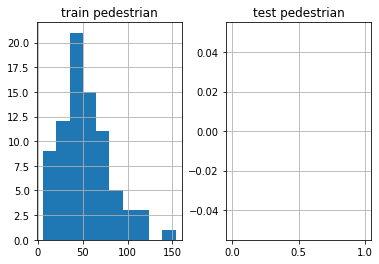

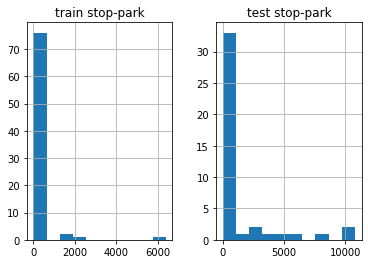

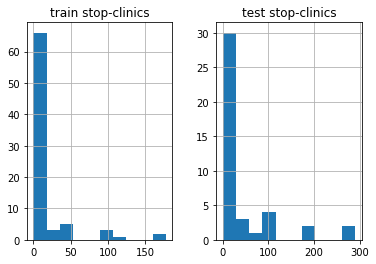

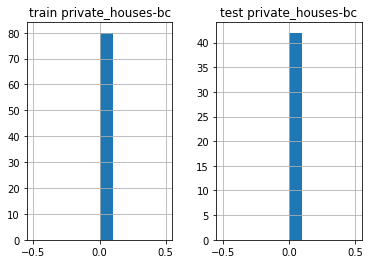

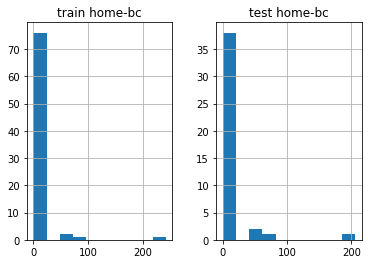

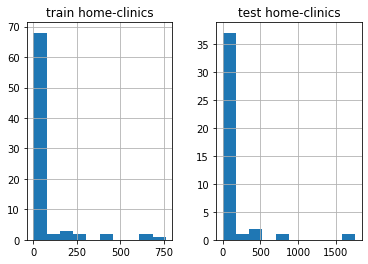

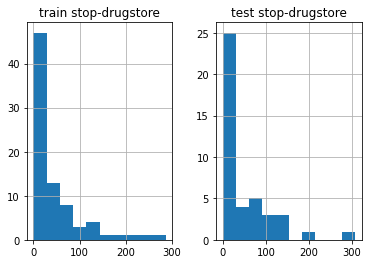

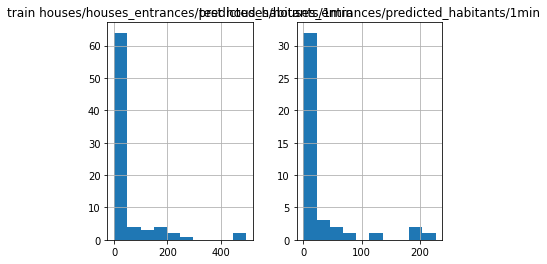

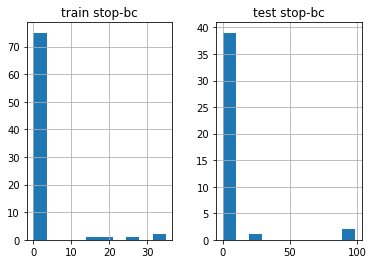

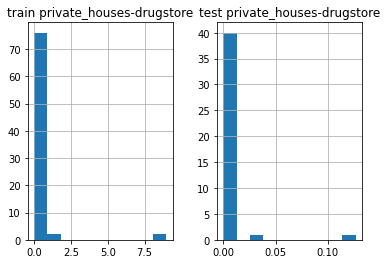

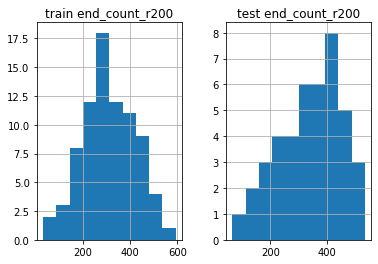

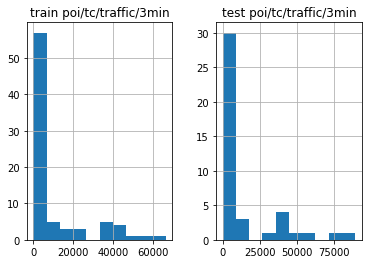

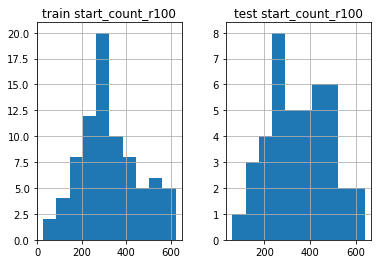

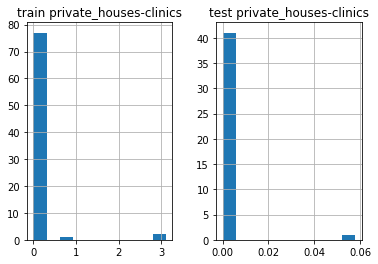

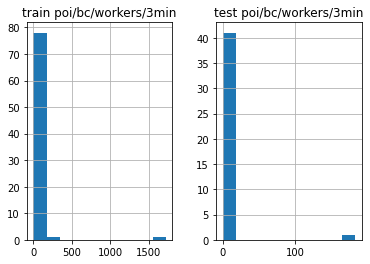

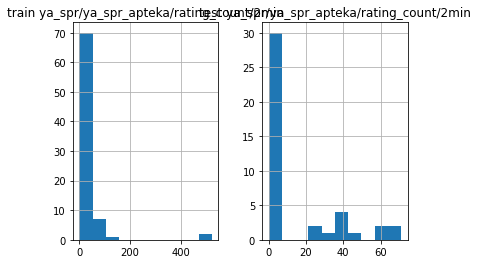

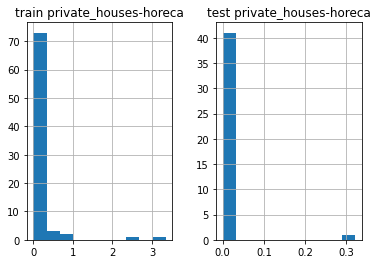

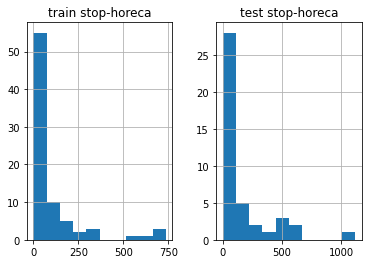

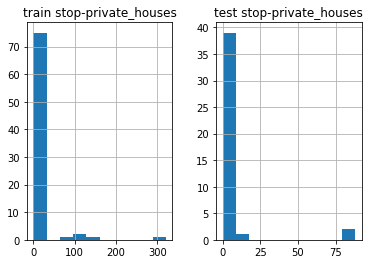

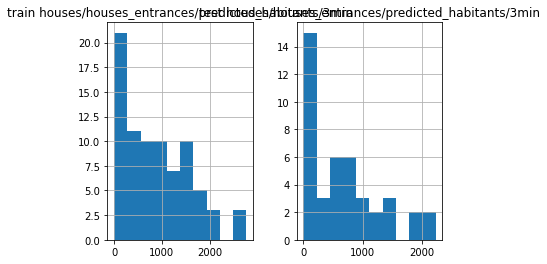

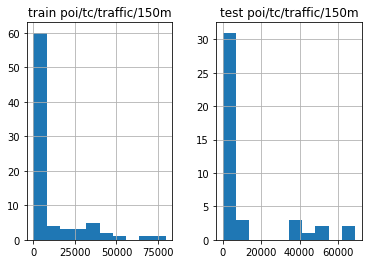

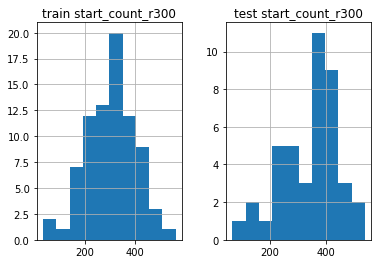

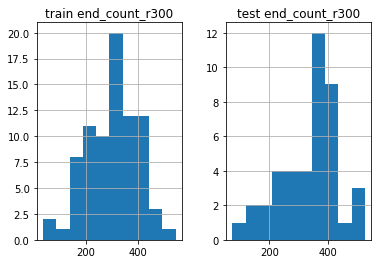

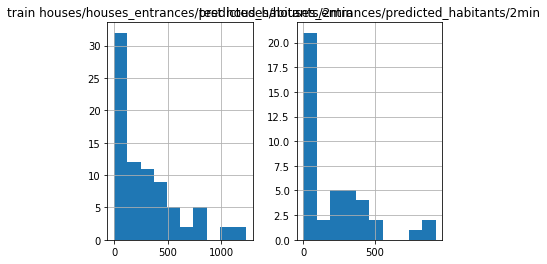

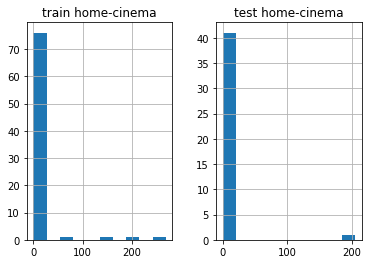

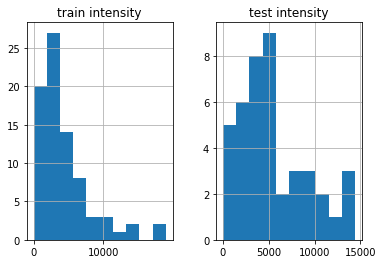

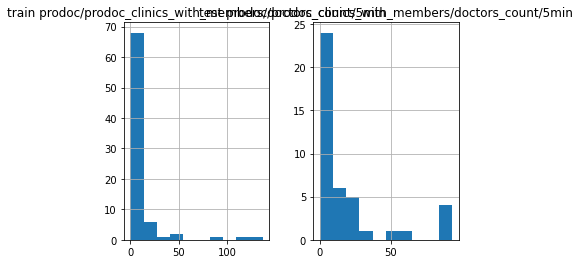

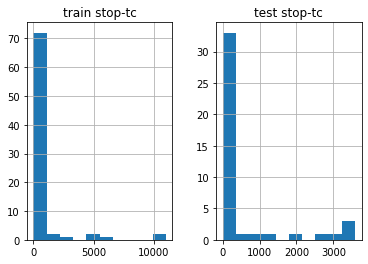

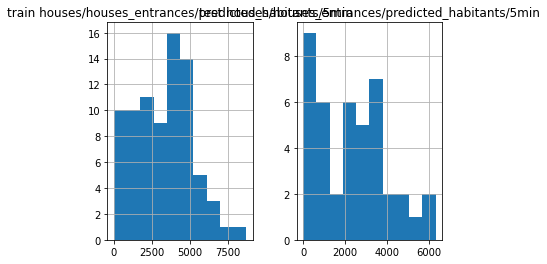

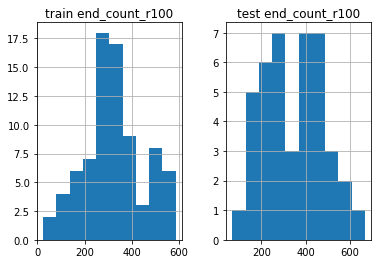

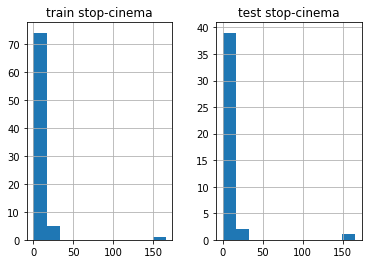

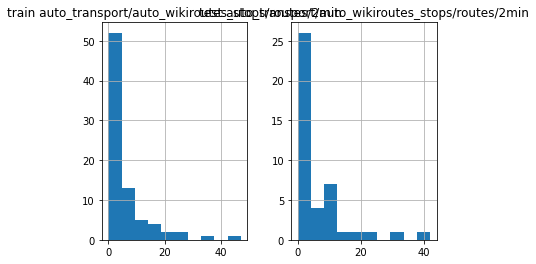

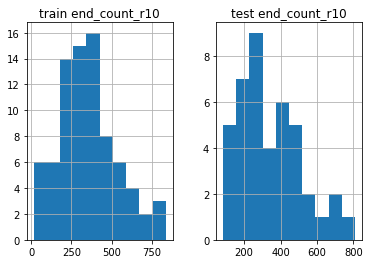

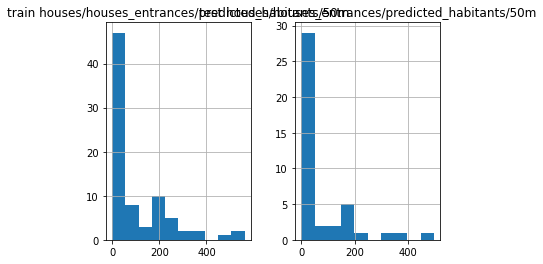

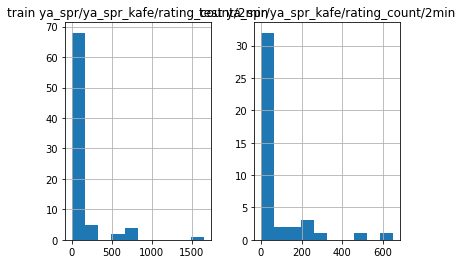

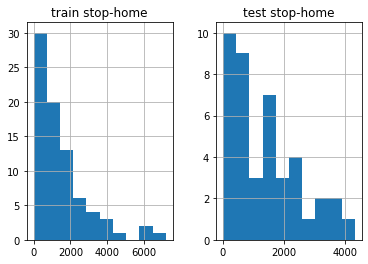

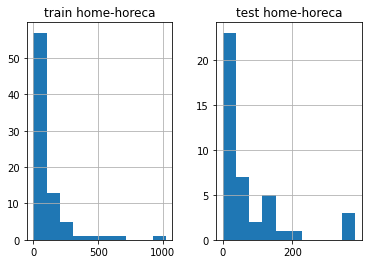

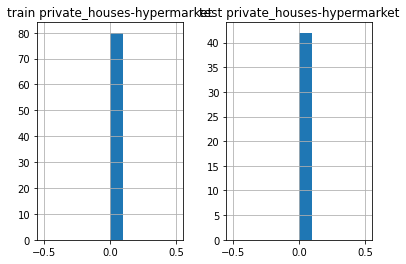

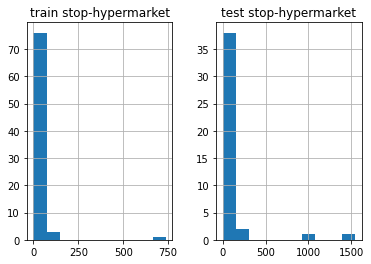

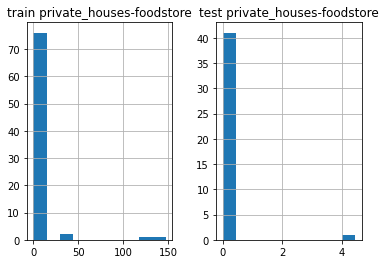

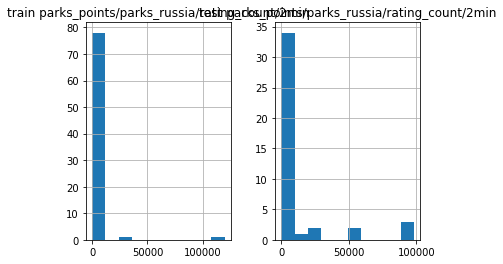

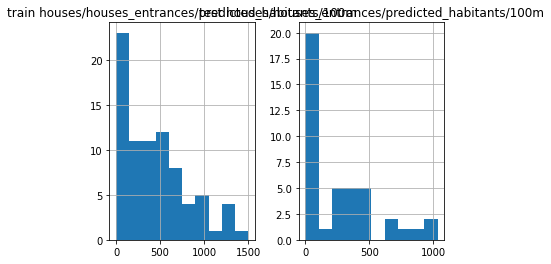

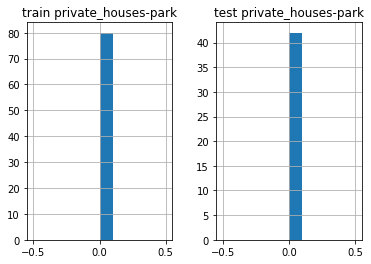

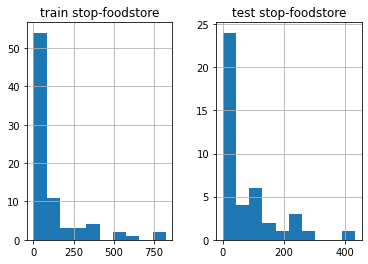

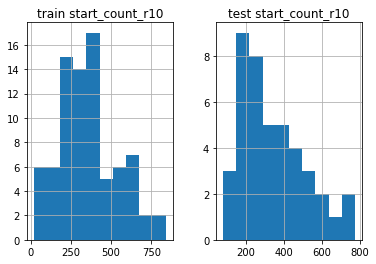

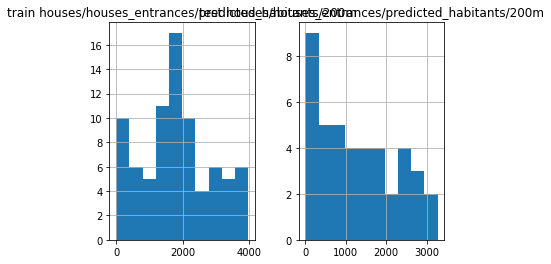

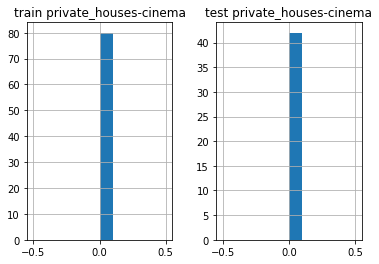

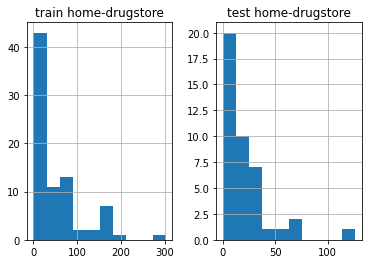

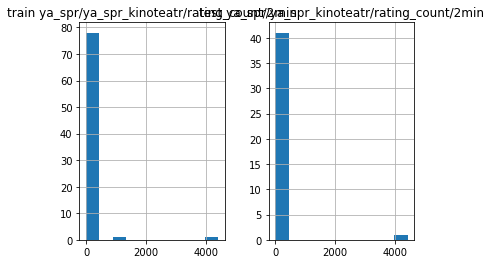

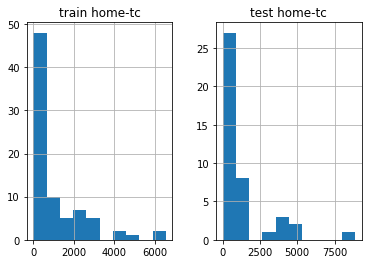

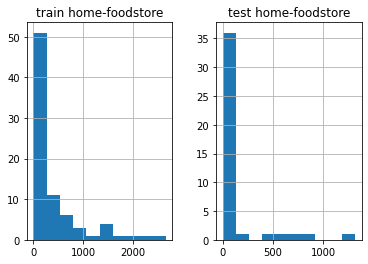

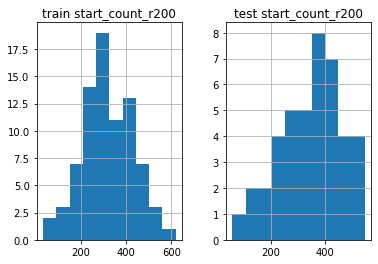

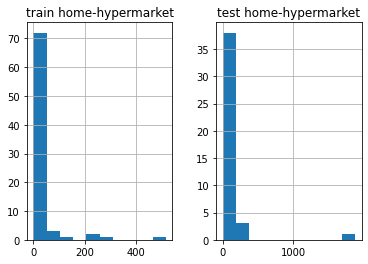

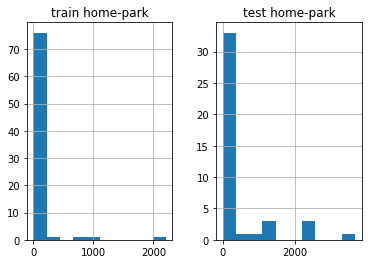

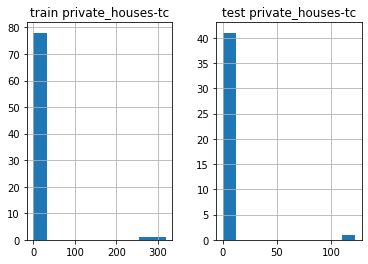

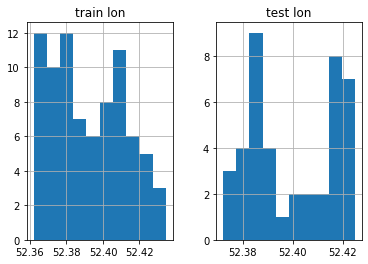

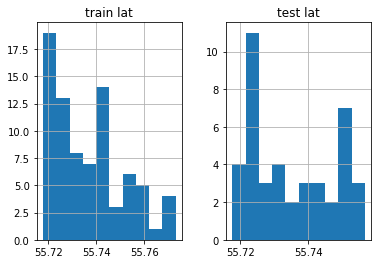

In [ ]:
for col_name in train.columns:
    try:
        figure, axis = plt.subplots(1, 2)
        train[[col_name]].hist(ax=axis[0])
        test[[col_name]].hist(ax=axis[1])
        axis[0].set_title(f'train {col_name}')
        axis[1].set_title(f'test {col_name}')
        plt.show()
    except ValueError:
        print(col_name)
    # break



Удаляем нулевые признаки

In [ ]:
columns_to_drop = ['private_houses-bc', 'private_houses-hypermarket', 'private_houses-park', 'private_houses-cinema']

In [ ]:
train = train.drop(columns_to_drop, axis=1)
test = test.drop(columns_to_drop, axis=1)

Проверяем корреляцию между признаками

In [ ]:
for i, col1 in enumerate(train.columns):
    for col2 in train.columns[i+1:]:
        corr = train[col1].corr(train[col2])
        if corr > 0.9:
            print(corr, col1, col2)

0.9240601841396903 stop-park home-park
0.9071751265089716 home-bc poi/bc/workers/3min
0.9434911572752211 end_count_r200 start_count_r100
0.965419757653558 end_count_r200 start_count_r300
0.9693288912181892 end_count_r200 end_count_r300
0.9493505489954861 end_count_r200 end_count_r100
0.9895756040451096 end_count_r200 start_count_r200
0.9039410486263503 poi/tc/traffic/3min poi/tc/traffic/150m
0.9858330391781899 start_count_r100 end_count_r100
0.9523501143965953 start_count_r100 start_count_r200
0.9919130635304106 start_count_r300 end_count_r300
0.971237100867532 start_count_r300 start_count_r200
0.9576034429288195 end_count_r300 start_count_r200
0.9355218659465266 end_count_r100 start_count_r200
0.9557513240377838 stop-cinema ya_spr/ya_spr_kinoteatr/rating_count/2min
0.9810862910930289 end_count_r10 start_count_r10
0.9552058474666675 private_houses-foodstore private_houses-tc


In [ ]:
train.reset_index(drop=True, inplace=True)

Визуализируем

In [ ]:
list(reversed(train.iloc[:,-3:-1].mean().values))

[52.39222498220901, 7.369918756966297]

In [ ]:
import folium

In [ ]:
map_center = list(reversed(train.iloc[:,-2:].mean().values))
m = folium.Map(location=map_center, zoom_start=12)


for i, row in train.iterrows():
    # point_coords = list(reversed(row.iloc[-3:-1].values))
    tooltip = row.pedestrian
    folium.Marker(
        [row.lat, row.lon],
        popup="<i>train</i>",
        tooltip=tooltip,
    ).add_to(m)


for i, row in test.iterrows():
    # point_coords = list(reversed(row.iloc[-3:-1].values))
    tooltip = row.pedestrian
    folium.Marker(
        [row.lat, row.lon],
        popup="<i>test</i>",
        tooltip=tooltip,
        icon=folium.Icon(color="red"),
    ).add_to(m)
m

#Modeling

In [ ]:
!pip install catboost

     |████████████████████████████████| 67.4 MB 28 kB/s 


In [ ]:
train.pedestrian.describe()

count     80.000000
mean      53.065142
std       28.534572
min        6.111111
25%       33.215909
50%       49.377193
75%       68.464286
max      153.384615
Name: pedestrian, dtype: float64

In [ ]:
from catboost import Pool, cv


# cat_features = [0]

cv_dataset = Pool(data=train.iloc[:,1:],
                  label=train[['pedestrian']],
                #   cat_features=cat_features
                  )

params = {
          "loss_function": "RMSE",
          "verbose": True,
          "early_stopping_rounds": 50}

scores = cv(cv_dataset,
            params,
            fold_count=5, 
            plot="True",
            seed=42)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 58.9770672	test: 58.7428143	best: 58.7428143 (0)
1:	learn: 58.0479647	test: 57.9837616	best: 57.9837616 (1)
2:	learn: 56.9727343	test: 56.9203161	best: 56.9203161 (2)
3:	learn: 56.1588549	test: 56.3303445	best: 56.3303445 (3)
4:	learn: 55.3132136	test: 55.5938749	best: 55.5938749 (4)
5:	learn: 54.5498701	test: 54.9468395	best: 54.9468395 (5)
6:	learn: 53.8121789	test: 54.4405201	best: 54.4405201 (6)
7:	learn: 53.0934802	test: 53.8442444	best: 53.8442444 (7)
8:	learn: 52.3702108	test: 53.2575580	best: 53.2575580 (8)	total: 286ms	remaining: 31.5s
9:	learn: 51.5550001	test: 52.5588284	best: 52.5588284 (9)
10:	learn: 50.6662256	test: 51.6924615	best: 51.6924615 (10)
11:	learn: 49.8685645	test: 50.9511744	best: 50.9511744 (11)
12:	learn: 49.1450335	test: 50.3488459	best: 50.3488459 (12)
13:	learn: 48.4267969	test: 49.7548138	best: 49.7548138 (13)
14:	learn: 47.7599892	test: 49.2339857	best: 49.2339857 (14)
15:	learn: 47.1489117	test: 48.7675538	best: 48.7675538 (15)
16:	learn: 46.

#prediction

In [ ]:
from catboost import CatBoostRegressor
# Initialize data

train = Pool(data=train.iloc[:,1:],
                  label=train[['pedestrian']],
                #   cat_features=cat_features
                  )
# Initialize CatBoostRegressor
model = CatBoostRegressor(iterations=290)
# Fit model
model.fit(train)
# Get predictions
# preds = model.predict(eval_data)

Learning rate set to 0.063786
0:	learn: 27.7024086	total: 3.14ms	remaining: 908ms
1:	learn: 27.2038132	total: 5.88ms	remaining: 846ms
2:	learn: 26.5813751	total: 8.56ms	remaining: 819ms
3:	learn: 25.9580491	total: 11.2ms	remaining: 803ms
4:	learn: 25.5107231	total: 13.9ms	remaining: 794ms
5:	learn: 24.9915118	total: 17.1ms	remaining: 808ms
6:	learn: 24.5130928	total: 19.7ms	remaining: 796ms
7:	learn: 24.1262214	total: 22.3ms	remaining: 786ms
8:	learn: 23.7838144	total: 24.9ms	remaining: 779ms
9:	learn: 23.4605070	total: 27.6ms	remaining: 773ms
10:	learn: 23.0382261	total: 30.2ms	remaining: 766ms
11:	learn: 22.6473754	total: 32.9ms	remaining: 761ms
12:	learn: 22.2429746	total: 35.5ms	remaining: 757ms
13:	learn: 21.8049060	total: 38.1ms	remaining: 752ms
14:	learn: 21.4158585	total: 40.7ms	remaining: 747ms
15:	learn: 21.0627693	total: 43.3ms	remaining: 742ms
16:	learn: 20.6933732	total: 46ms	remaining: 738ms
17:	learn: 20.4221268	total: 48.6ms	remaining: 734ms
18:	learn: 20.2501740	total:

In [ ]:
preds = model.predict(test.iloc[:,1:])

In [ ]:
preds

array([43.48524361, 94.7096795 , 38.81879676, 43.01555511, 76.72586217,
       76.62045695, 56.96160999, 37.32296085, 42.33551512, 30.51240913,
       45.9116479 , 43.72083862, 44.31060745, 53.52130734, 54.78772662,
       38.79387263, 57.61189948, 48.09066708, 58.22780849, 22.84836761,
       55.20438809, 65.21933606, 71.66089738, 68.09675309, 54.47204005,
       52.48719366, 68.99069599, 50.59046735, 62.94663237, 52.05987885,
       30.28809115, 75.25419054, 87.94498116, 88.66798485, 42.3070553 ,
       57.65176348, 45.839249  , 55.72345788, 44.70816177, 57.62375489,
       49.58622074, 42.55593352])